In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matlab_functions import load_mat 

## Load all MATLAB trajectories

In [2]:
trj_laneChange  = load_mat('../archive/v1_matlab/01_vehCfg/data/vehCfg_sm1_laneChange.mat')
trj_platooning  = load_mat('../archive/v1_matlab/01_vehCfg/data/vehCfg_sm2_platoonFormExit.mat')
trj_staticDrift = load_mat('../archive/v1_matlab/01_vehCfg/data/vehCfg_sm3_comparisonSoA.mat')

Verify that all trajectories have 1000 Hz sampling rate

In [3]:
dt_laneChange  = trj_laneChange['vehicle']['t']['dt']
dt_platooning  = trj_platooning['vehicle']['t']['dt']
dt_staticDrift = trj_staticDrift['vehicle']['t']['dt']

print('Lane change  dt:', dt_laneChange)
print('Platooning   dt:', dt_platooning)
print('Static drift dt:', dt_staticDrift)

Lane change  dt: 0.001
Platooning   dt: 0.001
Static drift dt: 0.01


OK turned out static drift trajectory actually has 100 Hz, so we'll have to resample it up to 1000 Hz at some point

## Some changes to the system model since v1 MATLAB

The old numbering/naming convention for the tx/rx units was not intuitive and we had different numbers for tx and rx, which was unnecessary. We're changing the naming convention in the new repository:

- **TX1 / RX4** in the old repo is **rear left   (RL)** in the new repo.
- **TX2 / RX3** in the old repo is **rear right  (RR)** in the new repo.
- **TX3 / RX2** in the old repo is **front left  (FL)** in the new repo.
- **TX4 / RX1** in the old repo is **front right (FR)** in the new repo.

<img src="old_system_model.png?1" width=500 align=left title="Old System Model">

----

For this new version of the simulator, we're only going to save the relative target trajectories (x/y) and headings since we're only dealing with the case where 1 target vehicle is leading 1 ego vehicle, the target tail-lights are TX, and ego head units are RX. Timestamps will regularly be in 1ms intervals, first sample starting with t=1ms, simulation length = number_of_samples * 1 ms.

So let's load variables from the old files based on this

## Isolate variables from MATLAB files

In [4]:
x_RL_laneChange  = trj_laneChange['vehicle']['target_relative']['tx1_qrx4']['x']
y_RL_laneChange  = trj_laneChange['vehicle']['target_relative']['tx1_qrx4']['y']
x_RR_laneChange  = trj_laneChange['vehicle']['target_relative']['tx2_qrx3']['x']
y_RR_laneChange  = trj_laneChange['vehicle']['target_relative']['tx2_qrx3']['y']
hdg_laneChange   = trj_laneChange['vehicle']['target_relative']['heading']

x_RL_platooning  = trj_platooning['vehicle']['target_relative']['tx1_qrx4']['x']
y_RL_platooning  = trj_platooning['vehicle']['target_relative']['tx1_qrx4']['y']
x_RR_platooning  = trj_platooning['vehicle']['target_relative']['tx2_qrx3']['x']
y_RR_platooning  = trj_platooning['vehicle']['target_relative']['tx2_qrx3']['y']
hdg_platooning   = trj_platooning['vehicle']['target_relative']['heading']

# This one needs to be interpolated to 1000 Hz sampling rate first
x_RL_temp  = trj_staticDrift['vehicle']['target_relative']['tx1_qrx4']['x']
y_RL_temp  = trj_staticDrift['vehicle']['target_relative']['tx1_qrx4']['y']
x_RR_temp  = trj_staticDrift['vehicle']['target_relative']['tx2_qrx3']['x']
y_RR_temp  = trj_staticDrift['vehicle']['target_relative']['tx2_qrx3']['y']
hdg_temp   = trj_staticDrift['vehicle']['target_relative']['heading']

old_tracer = np.arange(0, len(x_RL_temp)*10, 10)
new_tracer = np.arange(0, len(x_RL_temp)*10, 1)
x_RL_staticDrift  = np.interp(new_tracer, old_tracer, x_RL_temp)
y_RL_staticDrift  = np.interp(new_tracer, old_tracer, y_RL_temp)
x_RR_staticDrift  = np.interp(new_tracer, old_tracer, x_RR_temp)
y_RR_staticDrift  = np.interp(new_tracer, old_tracer, y_RR_temp)
hdg_staticDrift   = np.interp(new_tracer, old_tracer, hdg_temp)

## Check that the loaded trajectories match the ones in the TVT article

just a sanity check

### Lane change scenario

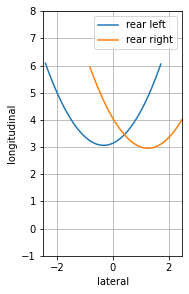

In [5]:
fig, ax = plt.subplots(figsize = (2.5,4.5))
ax.plot(x_RL_laneChange, y_RL_laneChange)
ax.plot(x_RR_laneChange, y_RR_laneChange)
ax.legend(['rear left', 'rear right'])

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-1.0, 8.0)
ax.set(xlabel='lateral', ylabel='longitudinal')
ax.grid()

Looks OK

<img src="lane_change.png?1" width=200 align=left title="Old System Model">

### Platooning scenario

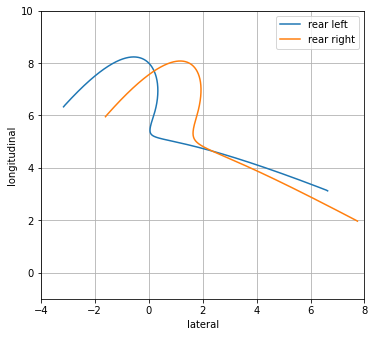

In [6]:
fig, ax = plt.subplots(figsize = (5.8, 5.3))
ax.plot(x_RL_platooning, y_RL_platooning)
ax.plot(x_RR_platooning, y_RR_platooning)
ax.legend(['rear left', 'rear right'])

ax.set_xlim(-4, 8)
ax.set_ylim(-1.0, 10.0)
ax.set(xlabel='lateral', ylabel='longitudinal')
ax.grid()

A bit off at the end. This is due to the manual trajectory generation error we experienced with v1 MATLAB (check private notes, Nov '2020)

So -> the trajectory plot (shown below) at the TVT article, and the results plot at the side, are for the same trajectory up until the x=4 mark, after that the trajectories are different (but the TX beam is out of the FoV anyhow, so it does not change the results. Perhaps we could add this as an addendum to the original paper or something, because it might be confusing.

<img src="platooning.png?3" width=900 align=left title="Old System Model">

### Static drift scenario

This was actually taken from: 

Béchadergue, B., Chassagne, L., & Guan, H. (2017, October). "_A visible light-based system for automotive relative positioning_". In 2017 IEEE SENSORS (pp. 1-3). IEEE. 

But the trajectory there assumed the vehicles were parallel to each other, yet the target vehicle still moved sideways -> this could only happen if both vehicles were moving at infinite speed in the same direction. So we changed it a bit, made both vehicles pretty fast so that the heading angle is still small (vehicles are sort of parallel), and interpreted each location on this trajectory as static cases, i.e., no change in signal power throughout the simulation for each point. See our TVT article for further details

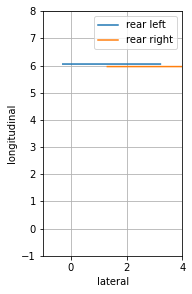

In [7]:
fig, ax = plt.subplots(figsize = (2.5,4.5))
ax.plot(x_RL_staticDrift, y_RL_staticDrift)
ax.plot(x_RR_staticDrift, y_RR_staticDrift)
ax.legend(['rear left', 'rear right'])

ax.set_xlim(-1.0, 4)
ax.set_ylim(-1.0, 8.0)
ax.set(xlabel='lateral', ylabel='longitudinal')
ax.grid()

Looks OK

<img src="static_drift.png?1" width=600 align=left title="Old System Model">

## Save the python dictionaries

this might not look like a dictionary, but it is loaded as such, see below

In [8]:
np.savez('../trajectories/generated_lanechange.npz', 
         x_RL = x_RL_laneChange,
         y_RL = y_RL_laneChange,
         x_RR = x_RR_laneChange,
         y_RR = y_RR_laneChange,
         hdg  = hdg_laneChange
        )

In [9]:
np.savez('../trajectories/generated_platooning.npz', 
         x_RL = x_RL_platooning,
         y_RL = y_RL_platooning,
         x_RR = x_RR_platooning,
         y_RR = y_RR_platooning,
         hdg  = hdg_platooning
        )

In [10]:
np.savez('../trajectories/generated_staticdrift.npz', 
         x_RL = x_RL_staticDrift,
         y_RL = y_RL_staticDrift,
         x_RR = x_RR_staticDrift,
         y_RR = y_RR_staticDrift,
         hdg  = hdg_staticDrift
        )

## Load and show access to the python dictionaries

In [11]:
aa = np.load('../trajectories/generated_lanechange.npz')

In [12]:
len(aa['x_RL'])

1000